## Project Template (Deepnote)

You can use this notebook as a starting point for your class project and/or the extra exercise for graduate students in Deepnote. It comes set up with the dependencies we use in class, so you don't have to install these yourself.

**Notes:**
- To use this in your own workspace, click “Duplicate” for the project in Deepnote.
- Class dependencies, namely `drake` and the `manipulation` package, are already preinstalled in the Deepnote image for this course, as well as a bunch of other dependencies that these packages depend on or that we use in class
- To see the full list of installed dependencies, as well as version numbers etc, see this file: [pyproject.toml](https://github.com/RussTedrake/manipulation/blob/master/pyproject.toml).
  - **Note**: we install all the extra dependencies, including the `dev` dependencies, into the Docker image that this deepnote project runs on.


### (Advanced Users) Installing additional dependencies

Here we show you how to install additional packages into this Deepnote project. We will use the package [gcsopt](https://pypi.org/project/gcsopt/) as an example. To install additional dependencies, you have two choices:
- **Recommended** (automatically installs your dependencies every time you boot the Deepnote machine):
  1. Add the dependency to the list of dependencies in `reqirements.txt` on the left.  
      - **Note**: Make sure to NOT remove the text that is already in the file. You should add your dependencies on new lines AFTER `manipulation=year.month.day`. For our example, the file contents will look like:
          ```
          --extra-index-url https://drake-packages.csail.mit.edu/whl/nightly
          manipulation==2025.9.23
          gcsopt
          ```
  2. Restart the Deepnote machine (or run the `Init` notebook)
- **Alternatively:** Run `!pip install gcsopt` within a cell in the Deepnote notebook. You will have to do this everytime you restart your Deepnote machine.

### (Advanced Users) Updating the `manipulation` version
We continually add new features to the `manipulation` package, which is automatically updated in Deepnote. However, after you first click "Duplicate", you will stop receiving these updates. Follow these steps to update your version to the latest version:
1. Find the latest version number for `manipulation` on the [PyPi package page](https://pypi.org/project/manipulation/#history).
2. Update the version number for `manipulation=year.month.day` in the `requirements.txt` file on the left
3. Restart the Deepnote machine (or run the `Init` notebook)

The changes will persist every time you start your Deepnote machine.

Good luck!

---


## Placeholder code: iiwa Simulation

As a starting point, the code below sets up a simple simulation with a single iiwa, visualized in Meshcat.

### Setup and imports
Let us first get our imports out of the way:

In [1]:
import os
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import trimesh
from pydrake.all import (
    AddFrameTriadIllustration,
    BasicVector,
    Concatenate,
    Context,
    Diagram,
    DiagramBuilder,
    Integrator,
    JacobianWrtVariable,
    LeafSystem,
    MultibodyPlant,
    PiecewisePolynomial,
    PiecewisePose,
    PointCloud,
    Rgba,
    RigidTransform,
    RobotDiagram,
    RollPitchYaw,
    RotationMatrix,
    Simulator,
    StartMeshcat,
    Trajectory,
    TrajectorySource,
)

from manipulation import running_as_notebook
from manipulation.exercises.grader import Grader
from manipulation.icp import IterativeClosestPoint
from manipulation.letter_generation import create_sdf_asset_from_letter
from manipulation.meshcat_utils import AddMeshcatTriad
from manipulation.station import (
    AddPointClouds,
    LoadScenario,
    MakeHardwareStation,
    RobotDiagram,
)
from manipulation.utils import RenderDiagram

/usr/local/lib/python3.12/dist-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


### Meshcat Visualization

As always, let's start Meshcat for our 3D visualization!

In [4]:
# Start meshcat for visualization
meshcat = StartMeshcat()
print("Click the link above to open Meshcat in your browser!")

INFO:drake:Meshcat listening for connections at http://localhost:7002


Click the link above to open Meshcat in your browser!


In [5]:
# A note: as an additional argument add `include_normals=True` to the `create_sdf_asset_from_letter` function.
# We also recommend you use a slightly smaller `letter_height_meters=0.15` and a rather high friction coefficient
# (we use mu_static = 1.17, mu_dynamic = 1.0 - roughly equal to the friction of rubber on granite) to make the
# letters easier to pick up. We'll study more complicated grasping strategies in future notebooks, but this is not
# the priority of this chapter so we'll cheat.

from pathlib import Path
from manipulation.letter_generation import create_sdf_asset_from_letter

output_dir = Path("assets")
output_dir.mkdir(parents=True, exist_ok=True)

your_initial = "A"

create_sdf_asset_from_letter(
    your_initial,             # just the letter as the first positional arg
    output_dir=output_dir,    # keep this as a keyword
    include_normals=True,     # might be include_normal in your version
    letter_height_meters=0.15,
    mu_static=1.17,
    mu_dynamic=1.0,
)

PosixPath('assets/A.sdf')

In [6]:
# TODO: Paste your table_sdf = ... code from Exercise 1.4 here
size_x = 0.8
size_y = 0.6
thickness = 0.05
mass = 10.0
mu_static = 1.0
mu_dynamic = 0.8
dissipation = 1.0

Ixx = (1.0/12.0) * mass * (size_y**2 + thickness**2)
Iyy = (1.0/12.0) * mass * (size_x**2 + thickness**2)
Izz = (1.0/12.0) * mass * (size_x**2 + size_y**2)

table_sdf = f"""<?xml version="1.0"?>
<sdf version="1.7" xmlns:drake="http://drake.mit.edu">
  <model name="table">
    <link name="table_top">
      <inertial>
        <mass>{mass}</mass>
        <inertia>
          <ixx>{Ixx}</ixx><iyy>{Iyy}</iyy><izz>{Izz}</izz>
          <ixy>0</ixy><ixz>0</ixz><iyz>0</iyz>
        </inertia>
      </inertial>

      <visual name="visual">
        <geometry><box><size>{size_x} {size_y} {thickness}</size></box></geometry>
        <material>
          <ambient>0.6 0.6 0.6 1</ambient>
          <diffuse>0.7 0.7 0.7 1</diffuse>
        </material>
      </visual>

      <collision name="collision">
        <geometry><box><size>{size_x} {size_y} {thickness}</size></box></geometry>
        <drake:proximity_properties>
          <drake:hunt_crossley_dissipation>{dissipation}</drake:hunt_crossley_dissipation>
          <drake:mu_static>{mu_static}</drake:mu_static>
          <drake:mu_dynamic>{mu_dynamic}</drake:mu_dynamic>
        </drake:proximity_properties>
      </collision>
    </link>
  </model>
</sdf>
"""

assets_dir = Path("assets")
assets_dir.mkdir(parents=True, exist_ok=True)
(assets_dir / "table.sdf").write_text(table_sdf)
print("Wrote", (assets_dir / "table.sdf").resolve())

Wrote /workspaces/Projects/robotic_manipulation/00-Pset-9/assets/table.sdf


In [ ]:
# Add the directives for the bimanual IIWA arms, table, and initials

def generate_bimanual_IIWA14_with_assets_directives_file() -> (
    tuple[Diagram, RobotDiagram]
):
    table_sdf = f"{Path.cwd()}/assets/table.sdf"
    letter_sdf = f"{Path.cwd()}/assets/{your_initial}.sdf"

    directives_yaml = f"""directives:
- add_model:
    name: table
    file: file://{table_sdf}
- add_weld:
    parent: world
    child: table::table_top
    X_PC:
        translation: [0.0, 0.0, -.025]
        rotation: !Rpy {{ deg: [0, 0, -90] }}
- add_model:
    name: iiwa
    file: package://drake_models/iiwa_description/sdf/iiwa7_no_collision.sdf
    default_joint_positions:
        iiwa_joint_1: [-1.57]
        iiwa_joint_2: [0.1]
        iiwa_joint_3: [0]
        iiwa_joint_4: [-1.2]
        iiwa_joint_5: [0]
        iiwa_joint_6: [ 1.6]
        iiwa_joint_7: [0]
- add_weld:
    parent: table::table_top
    child: iiwa::iiwa_link_0
    X_PC:
        translation: [.5, 0, .025]
        rotation: !Rpy {{ deg: [0, 0, -90] }}
- add_model:
    name: wsg
    file: package://manipulation/hydro/schunk_wsg_50_with_tip.sdf
- add_weld:
    parent: iiwa::iiwa_link_7
    child: wsg::body
    X_PC:
        translation: [0, 0, 0.09]
        rotation: !Rpy {{ deg: [90, 0, 90]}}

- add_model:
    name: {your_initial}_letter
    file: file://{letter_sdf}

"""
    os.makedirs("directives", exist_ok=True)

    with open(
        "directives/bimanual_IIWA14_with_table_and_initials_and_assets.dmd.yaml", "w"
    ) as f:
        f.write(directives_yaml)


generate_bimanual_IIWA14_with_assets_directives_file()

In [9]:
def create_bimanual_IIWA14_with_assets_scenario() -> None:
    # Build absolute file:// URIs for the two directives files
    dmd1 = (Path.cwd() / "directives" / "bimanual_IIWA14_with_table_and_initials_and_assets.dmd.yaml").resolve().as_posix()
    # dmd2 = (Path.cwd() / "directives" / "camera_directives.dmd.yaml").resolve().as_posix()

    # Part 1: directives (use file:// URIs)
    scenario_yaml = f"""# Station scenario
directives:
  - add_directives:
      file: file://{dmd1}
"""
#   - add_directives:
#       file: file://{dmd2}



    # Part 2: cameras (DICT form; fields your schema accepts)
#     scenario_yaml += """
# cameras:
#   camera0:
#     name: camera0
#     depth: true
#     X_PB:
#       base_frame: camera0::base
#   camera1:
#     name: camera1
#     depth: true
#     X_PB:
#       base_frame: camera1::base
#   camera2:
#     name: camera2
#     depth: true
#     X_PB:
#       base_frame: camera2::base
# """

    # Part 3: drivers
    scenario_yaml += """
model_drivers:
  iiwa: !IiwaDriver
    control_mode: position_only
    hand_model_name: wsg
  wsg: !SchunkWsgDriver {}
"""

    os.makedirs("scenarios", exist_ok=True)

    with open(
        "scenarios/bimanual_IIWA14_with_table_and_initials_and_assets.scenario.yaml",
        "w",
    ) as f:
        f.write(scenario_yaml)


create_bimanual_IIWA14_with_assets_scenario()

In [ ]:
def create_bimanual_IIWA14_with_table_and_initials_and_assets() -> (
    tuple[DiagramBuilder, RobotDiagram]
):
    # TODO: Load the scenario created above into a Scenario object
    scenario = LoadScenario(
        filename="scenarios/bimanual_IIWA14_with_table_and_initials_and_assets.scenario.yaml"
    )

    # TODO: Create HardwareStation with the scenario and meshcat
    station = MakeHardwareStation(scenario, meshcat=meshcat)

    # TODO: Make a DiagramBuilder, add the station, and build the diagram
    builder = DiagramBuilder()
    builder.AddSystem(station)

    # TODO: Add the point clouds to the diagram with AddPointClouds
    ports = AddPointClouds(scenario=scenario, station=station, builder=builder)

    # TODO: export the point cloud outputs to the builder
    if ports:
        for cam_name, pc_sys in ports.items():
            # pc_sys is a pydrake.perception.DepthImageToPointCloud System
            # Export its point cloud output
            try:
                # Newer Drake often names it "cloud"
                builder.ExportOutput(pc_sys.get_output_port("cloud"),
                                    f"{cam_name}.point_cloud")
            except Exception:
                # Fallback: use the first output port
                builder.ExportOutput(pc_sys.get_output_port(0),
                                    f"{cam_name}.point_cloud")

    # TODO: Return the builder AND the station (notice that here we will need both)
    return builder, station


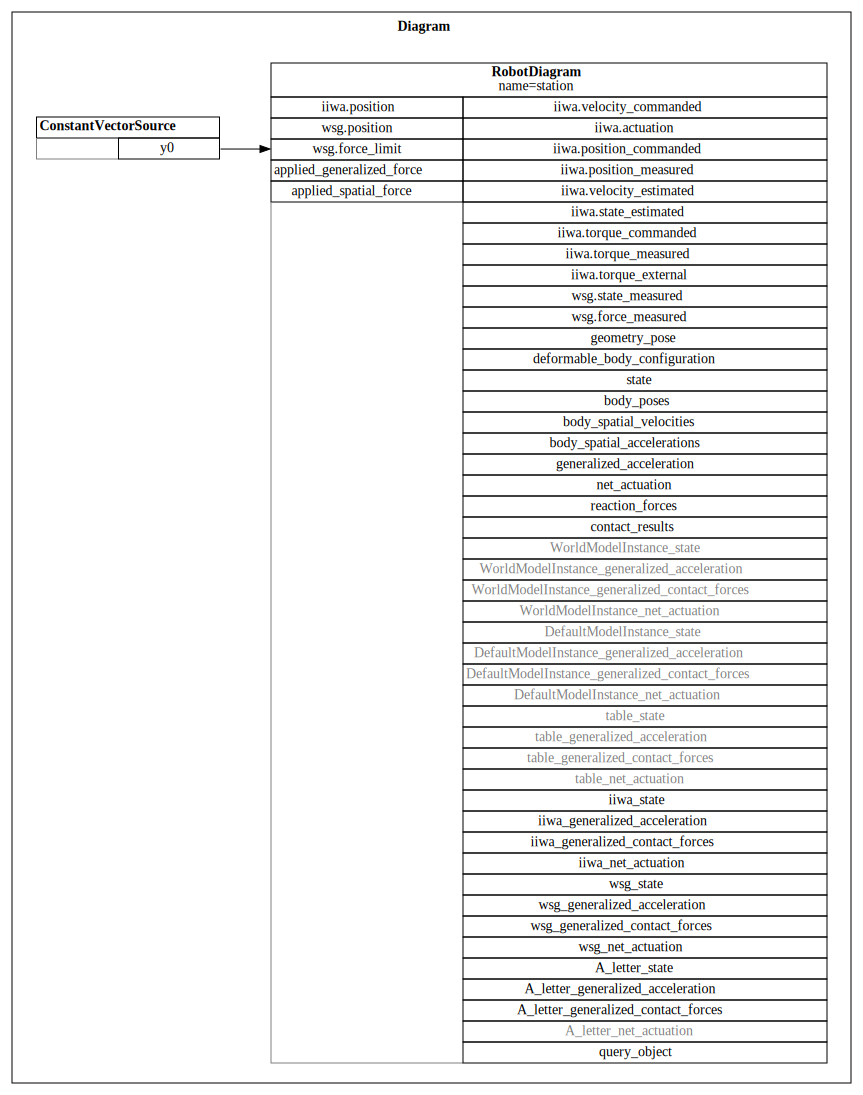

In [11]:
builder, station = (
    create_bimanual_IIWA14_with_table_and_initials_and_assets()
)

# in order to debug, we will build the diagram once here.
from pydrake.all import ConstantVectorSource
force_source = builder.AddSystem(ConstantVectorSource([100.0]))
builder.Connect(force_source.get_output_port(), station.GetInputPort("wsg.force_limit"))
diagram = builder.Build()

# visualize the diagram
RenderDiagram(diagram, max_depth=1)

# publish the diagram with some default context
context = diagram.CreateDefaultContext()
diagram.ForcedPublish(context)